# Variational Autoencoder (VAE)

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST

import matplotlib.pyplot as plt
import numpy as np

from typing import List, Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("Using device:", device)

Using device: cuda


Load MNIST dataset

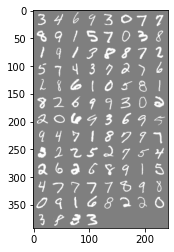

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = './data'
train_dataset = MNIST(path, transform=transform, download=True)
# test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Define network

In [3]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean:torch.Tensor, var:torch.Tensor):
        epsilon = torch.randn_like(var, device=var.device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

model = VAE().to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=200, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [4]:
class VAE(nn.Module):
    """Simple Variational Autoencoder class"""

    def __init__(self, in_dims:int, hidden_dims:List[int], latent_dim:int) -> None:
        super().__init__()

        # build encoder
        prev_dim = in_dims
        encoder_layers = []
        for hidden_dim in [*hidden_dims, latent_dim]:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.LeakyReLU(0.2))
            prev_dim = hidden_dim
        self._encoder = nn.Sequential(*encoder_layers)

        # also belongs to encoder:
        self._mean_layer = nn.Linear(latent_dim, 2)
        self._var_log_layer = nn.Linear(latent_dim, 2)

        # build decoder
        prev_dim = 2
        decoder_layers = []
        for hidden_dim in reversed([in_dims, *hidden_dims, latent_dim]):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.LeakyReLU(0.2))
            prev_dim = hidden_dim
        decoder_layers[-1] = nn.Sigmoid()
        self._decoder = nn.Sequential(*decoder_layers)

    def encode(self, x:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self._encoder(x)
        z_mean, z_var_log = self._mean_layer(x), self._var_log_layer(x)
        return z_mean, z_var_log
    
    def reparametrize(self, z_mean:torch.Tensor, z_var_log:torch.Tensor) -> torch.Tensor:
        epsilon = torch.randn_like(z_mean, device=z_mean.device)
        z = z_mean + torch.exp(z_var_log/2.)*epsilon
        return z
    
    def decode(self, z:torch.Tensor) -> torch.Tensor:
        x_hat = self._decoder(z)
        return x_hat
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        z_mean, z_var_log = self.encode(x)
        # print(f"{z_mean=}, {z_var_log=}")
        z = self.reparametrize(z_mean, z_var_log)
        # print(f"{z=}")
        x_hat = self.decode(z)
        # print(f"{x_hat=}")
        return x_hat, z_mean, z_var_log

model = VAE(in_dims=784, hidden_dims=[512], latent_dim=256).to(device)
print(model)

VAE(
  (_encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (_mean_layer): Linear(in_features=256, out_features=2, bias=True)
  (_var_log_layer): Linear(in_features=256, out_features=2, bias=True)
  (_decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## Beging training

In [5]:
def criterion(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [6]:
def train(model, optimizer, train_loader, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = criterion(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
train(model, optimizer, train_loader, epochs=50, device=device)

	Epoch 1 	Average Loss:  177.09408371048102
	Epoch 2 	Average Loss:  160.96704015155467
	Epoch 3 	Average Loss:  156.71845101536414
	Epoch 4 	Average Loss:  154.2767596058535
	Epoch 5 	Average Loss:  152.53585955433536
	Epoch 6 	Average Loss:  151.11188113000836
	Epoch 7 	Average Loss:  150.09159209033285
	Epoch 8 	Average Loss:  149.26685277871974


KeyboardInterrupt: 

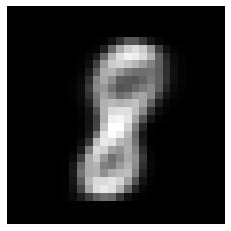

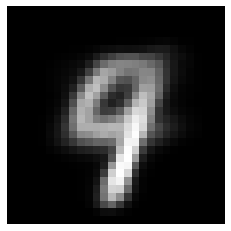

(None, None)

In [7]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

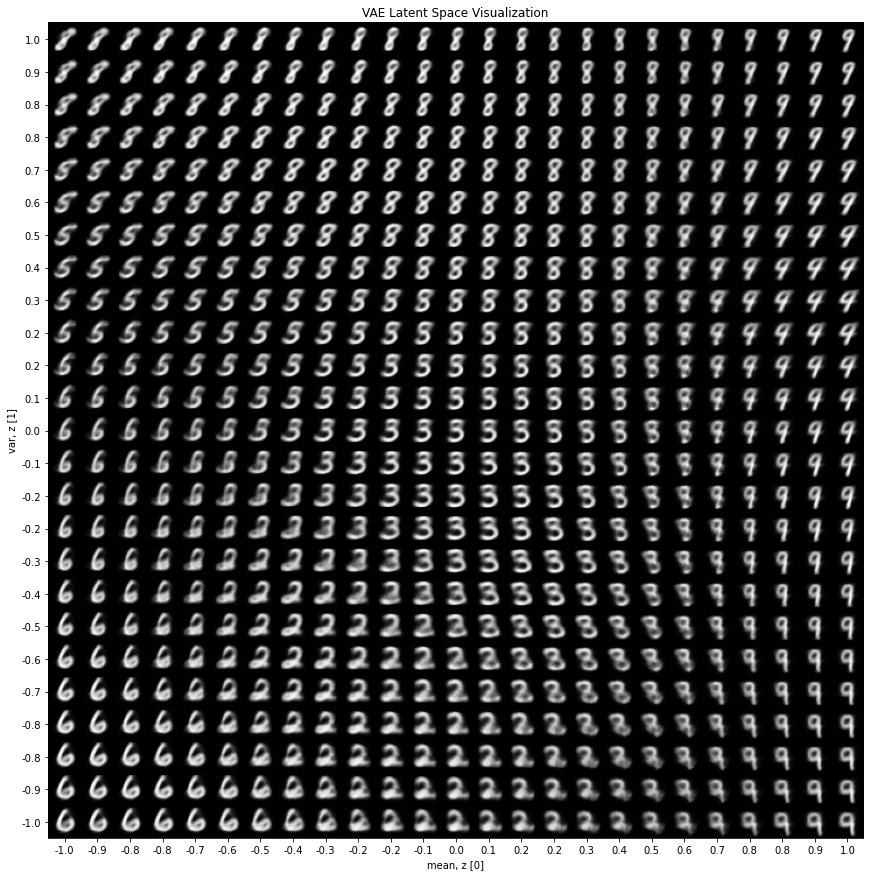

In [8]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)